# Exoplanet Nulling Explorer (ENE) -- GPU加速的极大似然消零干涉数据分析算法

Author: Ruiting Ma

E-mail: ruitingma@foxmail.com; mart@meayin.org

GitHub: https://github.com/Mary-Tim/Exoplanet-Nulling-Explorer

**前排提醒**：由于本人为粒子物理数据分析方向博士，在编写此算法前无天文相关专业经历，故若基于此算法开展工作时，请**务必**检查算法中所有天文学相关的定义、公式、参数单位约定等，**确保结果严谨性！！！**

**前序知识**：使用本算法需掌握基本的概率论与数理统计知识。本算法为DARWINsim、LIFEsim等消零数据产生与数据分析算法的GPU运算独立实现，在前人基础上进行了一定创新，请精读LIFE合作组第二篇文章[arXiv:2203.00471](https://arxiv.org/abs/2203.00471)后再开始本算法学习。

## 算法架构与功能

### 基本架构

本算法为基于pytorch与scipy等算法包开发的消零干涉仿真与数据分析算法，可基于GPU SIMD特性加速消零干涉数据产生与数据分析流程，支持多GPU并行化加速，大大降低数据产生与数据分析时间。
同时兼具良好的扩展性，可由用户自定义目标特性、光谱、传输图等模型，支撑未来地基与天基消零干涉望远镜阵列的预研究与数据分析工作。
算法的基本架构如图所示：

![Algorithm_functions](./figure/1_1_Algorithm_architecture.jpg)

1. 算法的所有“模型”均继承自`torch.nn.Module`，从而充分利用torch的自动微分特性，加速似然值求解。此处模型包括信号与本底振幅、传输图、仪器特性、似然函数等等。
2. 支持通过python的`dict`或YAML文件的形式创建观测计划与目标特性模型（下称振幅模型），方便用户使用。
3. 极大似然法求解通过`scipy.optimize.basinhopping`实现，可对多维参数空间进行快速搜索，找到极大似然值；支持多GPU并行加速运算，进一步加快求解过程。
4. 仿真数据与参数重建结果均可一键存储为`hdf5`文件，方便MC研究、二次作图展示等。

### 实现功能

本算法的基本功能如下图所示：

![Algorithm_functions](./figure/1_2_Algorithm_functions.jpg)

1. 消零干涉数据仿真：功能类似LIFEsim，支持任意指定行星数目、参数、恒星及其他本底参数，以及仪器和传输图参数、光谱配置、观测时间等，产生所需消零干涉仿真数据。
2. 消零干涉参数重建: 采用极大似然法进行消零干涉数据分析，进行行星参数重建，可重建行星位置及光谱信息等。重建过程中所有参数均可任意浮动！（DARWINsim参数求解时，只有光谱参数可浮动，位置参数需扫描，位置参数精度受限于扫描精度，ENE算法不存在此问题。）
3. 行星观测显著性估计：计算消零干涉模式下考虑所有本底贡献后的行星观测显著性，泊松估计。
4. 行星显著性$\chi^2$估计：产生toy MC，使用假设检验方法计算行星显著性。
5. 全周期观测效能估计：接受P-pop列表输入，估计全周期观测效能。

## 安装
ENE 算法是基于pytorch开发的GPU加速算法，为使用该算法，需首先配置好CUDA/ROCm环境，并部署pytorch。
之后，ENE算法可通过pip安装：
```bash
cd /path/to/ENE
pip install -r requirements.txt
pip install .
```

## 消零干涉观测仿真

通过填写两个简单的`dict`（或者读入yaml文件），我们就可以得到仿真的消零干涉输出数据：

首先是observation的配置，以下是一个observation dict的事例。

In [1]:
obs_config = {
    'Spectrum':{
        'Type': 'Resolution',
        'R': 20,
        'Low': 5.,
        'High': 17.,        # unit: micrometer
    },
    'Observation':{
        'ObsNumber': 360,
        'IntegrationTime': 200,  # unit: second
        'ObsMode': [1, -1],  # [1] or [-1] or [1, -1]
        'Phase':{
            'Start' : 0.,
            'Stop': 360.,   # unit: degree
        },
        'Baseline':{
            'Type': 'Constant',
            'Value': 30.,  # unit: meter
        },
    },
    'Configuration':{
        # Formation parameters
        'ratio':    6,          # ratio of imaging baseline versus nulling baseline [dimensionless]]
        'formation_longitude': 0.,  # Formation longitude [degree] 
        'formation_latitude' : 0.,  # Formation latitude [degree] 
        # Instrument parameters
        'mirror_diameter': 4,   # Diameter of MiYin primary mirror [meter]
        'quantum_eff': 0.7,     # Quantum efficiency of detector [dimensionless]
        'instrument_eff': 0.05, # Instrument throughput efficiency [dimensionless]
        'nulling_depth': 0.,    # Nulling depth of the instrument [dimensionless, within [0,1) ]
    }
}

其中"Spectrum"为观测光谱配置，，"Observation"为观测配置，"Configuration"仪器及阵列参数配置。具体调用方法参见`ObservationCreator`类。

而后，我们就可以通过`ObservationCreator`类来生成空的仿真数据。

In [2]:
import torch
torch.set_default_device('cuda:0')
torch.set_default_dtype(torch.float64)

from nullingexplorer.generator import ObservationCreator

obs_creator = ObservationCreator()
obs_creator.load(obs_config)
data = obs_creator.generate()
print(data)

TensorDict(
    fields={
        baseline: Tensor(shape=torch.Size([18000]), device=cuda:0, dtype=torch.float64, is_shared=True),
        intg_time: Tensor(shape=torch.Size([18000]), device=cuda:0, dtype=torch.float64, is_shared=True),
        mod: Tensor(shape=torch.Size([18000]), device=cuda:0, dtype=torch.int64, is_shared=True),
        pe_uncertainty: Tensor(shape=torch.Size([18000]), device=cuda:0, dtype=torch.float64, is_shared=True),
        phase: Tensor(shape=torch.Size([18000]), device=cuda:0, dtype=torch.float64, is_shared=True),
        photon_electron: Tensor(shape=torch.Size([18000]), device=cuda:0, dtype=torch.float64, is_shared=True),
        wl_hi: Tensor(shape=torch.Size([18000]), device=cuda:0, dtype=torch.float64, is_shared=True),
        wl_lo: Tensor(shape=torch.Size([18000]), device=cuda:0, dtype=torch.float64, is_shared=True),
        wl_mid: Tensor(shape=torch.Size([18000]), device=cuda:0, dtype=torch.float64, is_shared=True)},
    batch_size=torch.Size([18000]

`ObservationCreator`返回的`data`对象为`tensordict`对象，其中包含了每一个“数据点”的信息。

通过`print(data)`我们可以看到，其中包含了每个数据点的基线、相位、波段、积分时间、输出模式、光电子数等等。

注意此时光电子数及其误差为空，因为我们还未进行消零干涉数据仿真，只是创建了一个观测计划。

接下来是定义观测目标，生成观测目标的“振幅”，振幅包含行星信号、恒星泄漏、宿主恒星系黄道尘、太阳系黄道尘、电子学本底等等，可按需添加。

同样的，我们先写一个`dict`，然后将它传给振幅生成器，`AmplitudeGenerator`类，就完成了目标振幅的创建。

以距离太阳系10pc的太阳-地球二体系统为例：

In [3]:
gen_amp_config = {
    'Amplitude':{
        'earth':{
            'Model': 'PlanetCartesianCoordinates',
            'Parameters':
            {
                'ra':            {'mean': 62.5},
                'dec':            {'mean': 78.1},
            },
            'Spectrum': {
                'Model': 'BlackBodySpectrum',
                'Parameters':
                {
                    'radius':         {'mean': 6371.e3},
                    'temperature':    {'mean': 285.},
                },
            },
        },
        'star':{
            'Model': 'StarBlackBodyMatrix',
        },
        'local_zodi':{
            'Model': 'LocalZodiacalDustMatrix',
        },
        'exo_zodi':{
            "Model": 'ExoZodiacalDustMatrix',
        },
    },
    'Instrument': 'MiYinBasicType',
    'TransmissionMap': 'DualChoppedDestructive',
    'Configuration':{
        'distance': 10,         # distance between Miyin and target [pc]
        'star_radius': 695500,  # Star radius [kilometer]
        'star_temperature': 5772,   # Star temperature [Kelvin]
        'target_longitude': 0.,     # Ecliptic longitude [degree]
        'target_latitude': 30.,      # Ecliptic latitude  [degree]
        'zodi_level': 3,        # scale parameter for exo-zodi [dimensionless]
    }
}

`dict`中最重要的部分为是`Amplitude`字段，它定义了目标的振幅模型。

`Amplitude`字段中，每一个键值对都定义了一个振幅模型，键为模型的名称，值为模型的参数。

`Amplitude`允许添加任意多个不重名振幅，支持仿真任意数目的行星目标。

`Instrument`对应着观测仪器的配置，`TransmissionMap`对应着观测仪器的传输函数，`Configuration`对应着观测目标的参数，均应按需更改。

而后，仅需一行命令，即可生成该恒星系目标的总振幅：

In [4]:
from nullingexplorer.generator import AmplitudeCreator

gen_amp = AmplitudeCreator(gen_amp_config)

有了观测计划和振幅模型，我们就可以产生消零干涉数据了。

方法很简单，将观测计划“传给”振幅模型，即完成了一次观测模拟。

由于本底模拟涉及三重积分，需要一定运行时间。

In [5]:
from nullingexplorer.io import DataHandler

data['photon_electron'] = torch.poisson(gen_amp(data))
data_handler = DataHandler(data)
diff_data = data_handler.diff_data(obs_creator)

这里第一行首先将观测计划，即`data`传给振幅模型，得到每个“数据点”的光电子数期望，而后取泊松，即得到一次观测的光电子数。

对于 dual chopped Bracewell 干涉仪，我们还需要对数据的两个输出模式相减。

此时我们需要`DataHandler`类的帮助，DataHandler类内置的diff_data函数可自动将两个输出模式相减，并重新整理`data`纬度。

注意：对于Single Bracewell构型，无需进行该操作。

得到产生的数据后，我们可以通过`DataHandler`类的`draw`函数，方便的绘制仿真结果。也可使用`save`函数将仿真数据存入`hdf5`文件中，此处不再演示。

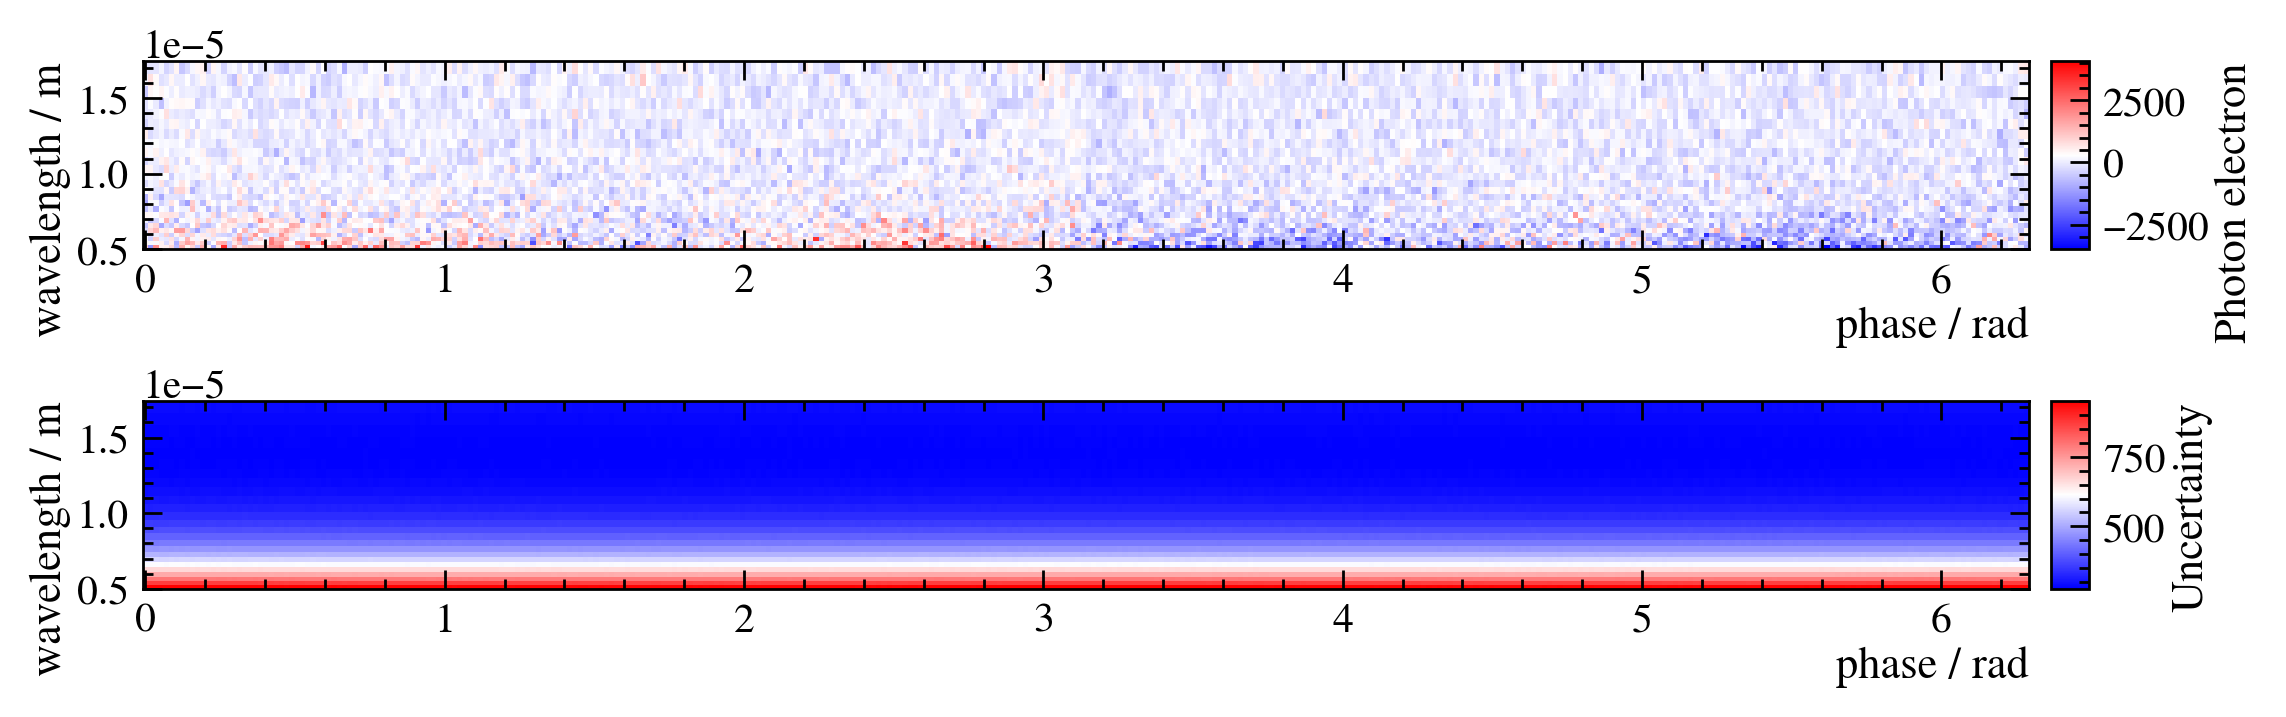

In [6]:
data_handler.draw(obs_creator=obs_creator, draw_err=True)

至此，我们便完成了一次消零干涉观测仿真。

## 消零干涉参数重建

ENE算法的消零干涉观测仿真与参数重建均依赖于`AmplitudeCreator`类，构建振幅模型。

二者的区别是，在观测仿真中，行星的参数是已知的，仅需在仿真中指定确定值即可。

而在参数重建中，我们通过极大似然方法，在多维参数空间中搜寻潜在的行星参数，解释仿真数据，此时所有的行星参数均为待定参数，需在拟合中浮动。

因此，我们需要创建一个新的`AmplitudeCreator`类，并指定相关参数。首先，让我们创建一个`dict`用于拟合。

In [7]:
fit_amp_config = {
    'Amplitude':{
        'earth':{
            'Model': 'PlanetSpectrum',
            'Orbit':
            {
                'Model': 'StaticPolarCoordinates',
                'Parameters':
                {
                    'au':        {'mean': 1., 'min': 0.1, 'max': 3., 'fixed': False},
                    'polar':          {'mean': 0., 'min': 0., 'max': 2.*torch.pi, 'fixed': False},
                },
            },
            'Spectrum': {
                'Model': 'RelativeBlackBodySpectrum',
                'Parameters':
                {
                    'r_radius':         {'mean': 1.e-5, 'min': 1e-3, 'max': 5., 'fixed': False},
                    'r_temperature':    {'mean': 1.e-5, 'min': 1e-3, 'max': 5., 'fixed': False},
                },
            },
        },
    },
    'Instrument': 'MiYinBasicType',
    'TransmissionMap': 'DualChoppedDifferential',
    'Configuration':{
        'distance': 10,         # distance between Miyin and target [pc]
        'star_radius': 695500,  # Star radius [kilometer]
        'star_temperature': 5772,   # Star temperature [Kelvin]
        'target_longitude': 0.,     # Ecliptic longitude [degree]
        'target_latitude': 30.,      # Ecliptic latitude  [degree]
        'zodi_level': 3,        # scale parameter for exo-zodi [dimensionless]
    }
}

可以看到，参数拟合选用的行星Model与Spectrum与观测仿真有所不同，这是由`scipy`最优化方法特性决定的。

在参数拟合时，我们需将待定参数尽可能归一到O(1)的量级，从而更快的收敛。

创建好`dict`后，我们同样仅需几行命令即可完成行星参数重建。

{}
Searching planet earth...
Random scanning...
Num of params: 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [08:47<00:00,  1.32s/it]


Precision searching...
LL: 10162.518
Inverse hessian matrix:
[[ 3.44971076e-06  4.89376255e-08  4.87181776e-05 -3.30659904e-05]
 [ 4.89376255e-08  4.11309478e-06 -2.66495974e-05  1.80997420e-05]
 [ 4.87181776e-05 -2.66495974e-05  1.61715187e-02 -1.05549367e-02]
 [-3.30659904e-05  1.80997420e-05 -1.05549367e-02  7.17287057e-03]]
earth.au:	1.000 +/- 0.002	[]
earth.polar:	0.896 +/- 0.002	[]
earth.spectrum.r_radius:	0.844 +/- 0.127	[6371e3 * kilometer]
earth.spectrum.r_temperature:	1.083 +/- 0.085	[285 * Kelvin]


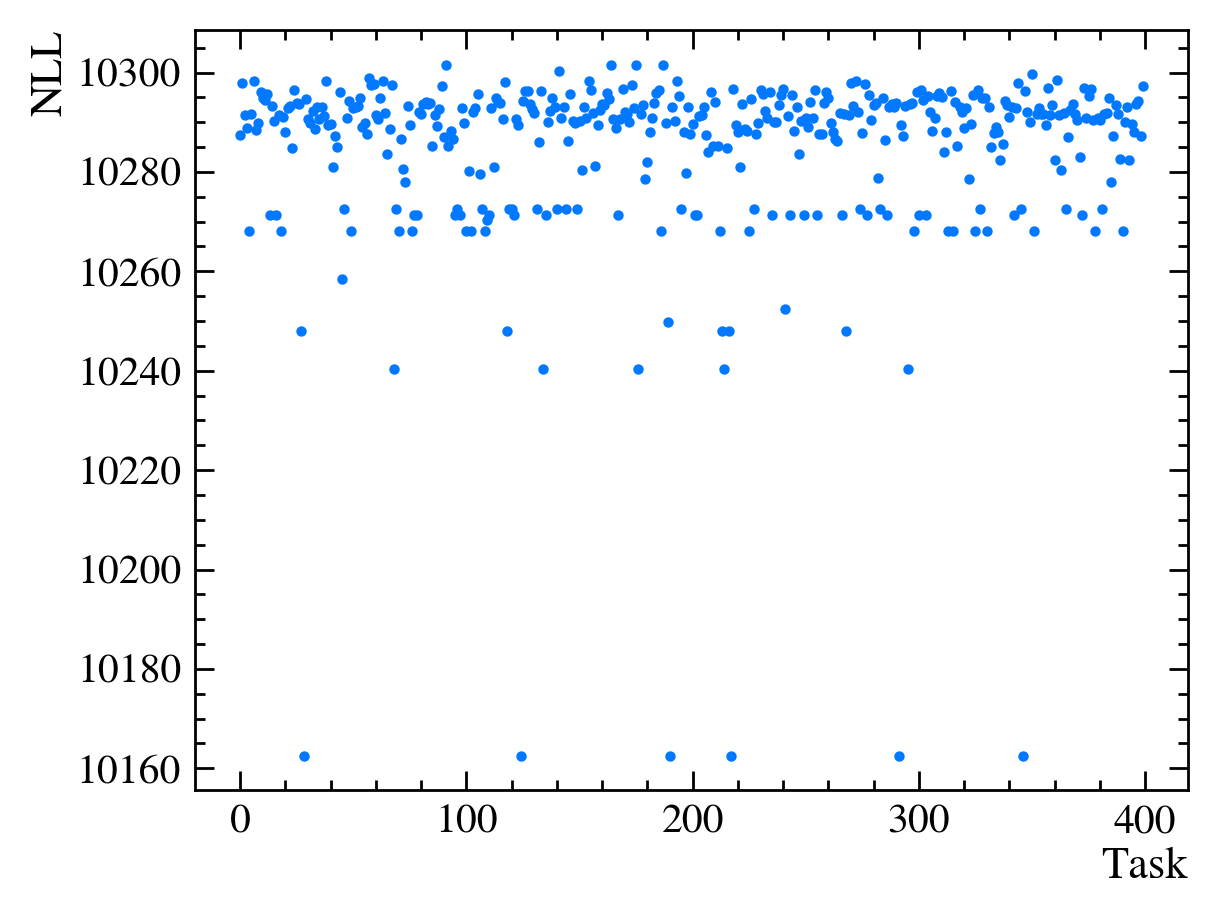

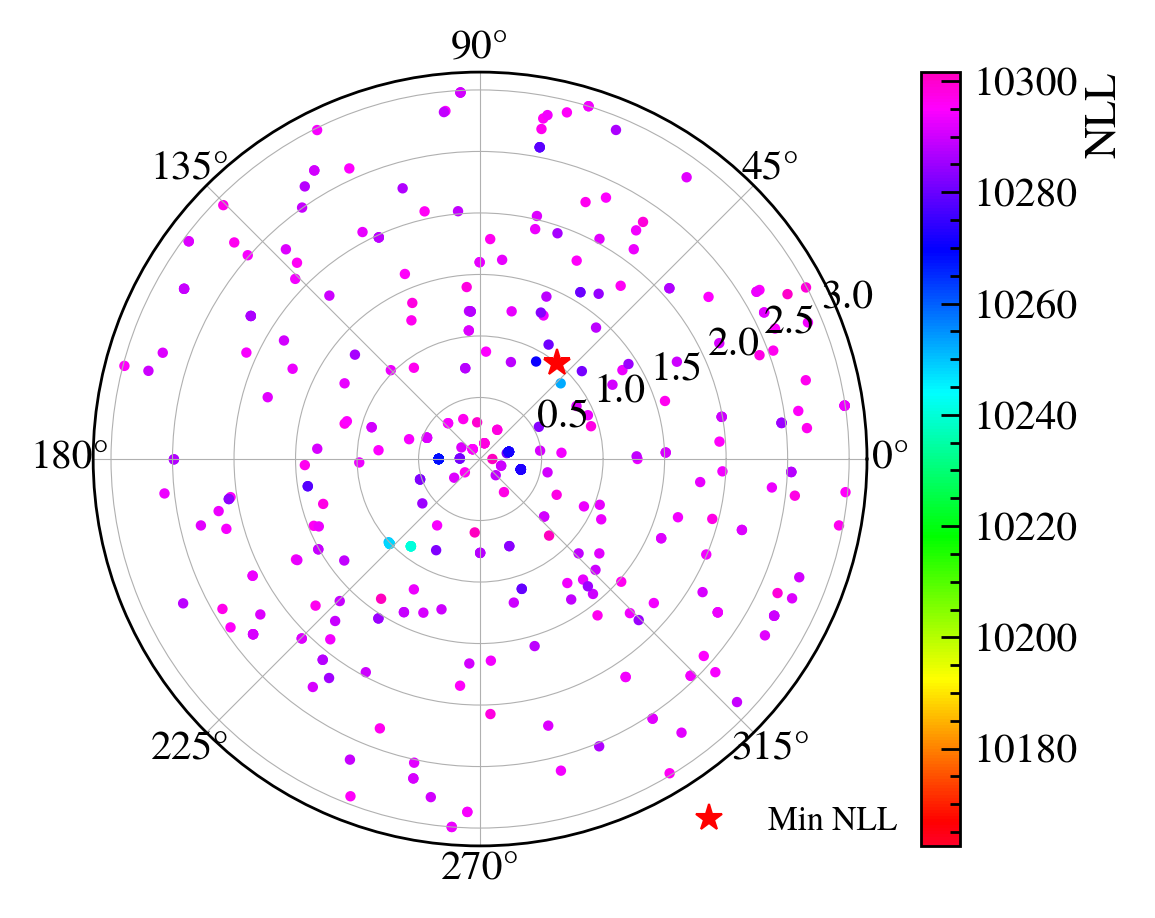

                    message: ['success condition satisfied']
                    success: True
                        fun: 10162.518146230825
                          x: [ 9.997e-01  8.960e-01  8.438e-01  1.083e+00]
                        nit: 694
      minimization_failures: 329
                       nfev: 2257
                       njev: 2257
 lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                              success: True
                               status: 0
                                  fun: 10162.518146230825
                                    x: [ 9.997e-01  8.960e-01  8.438e-01
                                         1.083e+00]
                                  nit: 22
                                  jac: [-2.026e-03 -1.972e-04 -1.024e-04
                                        -1.712e-04]
                                 nfev: 27
                                 njev: 27
                             hess_inv: <4x

In [8]:
from nullingexplorer.fitter import ENEFitter

fit_model = AmplitudeCreator(config=fit_amp_config)
fitter = ENEFitter(fit_model, diff_data, auto_save=False, multi_gpu=False, check_boundary=False)
fitter.search_planet('earth', draw=True, std_err=True, show=True, random_number=400, position_name=['earth.orbit.polar', 'earth.orbit.au'], polar=True)